# House Price Prediction

## Contents

### 1. [Introduction](#Introduction)

### 2. [Data](#data)
 
  2.1 [Load Data](#load)
  
  2.2 [Data Cleaning](#data_cleaning)
   
### 3. [Models](#models) 

  3.1 [Linear Regression](#lasso)
  
  3.2 [Xgboost](#xgboost)
 
 3.3 [LightGBM](#LightGBM)
 
 3.4 [Random Forest](#rf)
 
  3.5 [Stacking Models](#stacking)

  
### 4. [Predictions](#predictions)


<a id="Introduction"></a>
# 1. Introduction

Competition Description:  
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence. With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

Acknowledgments:  
The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset. 

<a id="data"></a>
# 2. Data

Kaggle provide the script to pull data from given path.

In [2]:
#Load data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#get training data and testing data
train_data = pd.read_csv('https://raw.githubusercontent.com/huynguyenphu/documents/master/train.csv')
test_data = pd.read_csv('https://raw.githubusercontent.com/huynguyenphu/documents/master/test.csv')

<a id="load"></a>
## 2.1 Load Data

In [3]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train_data.shape))
print("The test data size before dropping Id feature is : {} ".format(test_data.shape))

#Save the 'Id' column
train_ID = train_data['Id']
test_ID = test_data['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train_data.drop("Id", axis = 1, inplace = True)
test_data.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train_data.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test_data.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


<a id="data_cleaning"></a>
## 2.2 Data Cleaning

### Outliers

In [4]:
#handling outlier in the training data
#We do a pair scatter plot between the reponds and its highly correlated predictors and find possible outliers.

import matplotlib.pyplot as plt
import seaborn as sns

#Setting style to 'darkgrid'
sns.set_style('darkgrid')
corrmat = train_data.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.6]
sns.pairplot(train_data[top_corr_features], diag_kind='kde')

#Based on the pairplot, we remove the outlier that "GrLivArea" is larger than 4000
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000)].index)

### Missing Values

In [5]:
#processing the train and test data simulatously.
ntrain = train_data.shape[0]
ntest = test_data.shape[0]
y_train = train_data.SalePrice.values
all_data = pd.concat((train_data, test_data),sort=False).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2915, 79)


In [6]:
#handleing missing value

# miss_number=all_data.isnull().sum()
# miss_ratio=all_data.isnull().sum()/len(all_data)
# miss_info=pd.DataFrame({'Number of miss':miss_number,'Proportion of miss':miss_ratio},)
# miss_info=miss_info.loc[miss_info['Number of miss']>0]
# miss_info=miss_info.sort_values(by='Number of miss',ascending=0)
# print(miss_info)

#fill missing values
import copy
all_data2=copy.copy(all_data)

#By description, the following missing data are replaced by "None"
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence','FireplaceQu','GarageType', 
            'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 
            'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"MasVnrType"):
    all_data2[col] = all_data2[col].fillna('None')

#By descriotion, the following missing data are replaced by number 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 
            'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',"MasVnrArea"):
    all_data2[col] = all_data2[col].fillna(0)

#For "LotFrontage", we fill in missing values by the median LotFrontage of the neighborhood.
all_data2["LotFrontage"] = all_data2.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    
#there is only one missing value for the following variable, just replace it by the mode. 
all_data2['Electrical'] = all_data2['Electrical'].fillna(all_data2['Electrical'].mode()[0])

# miss_number=all_data2.isnull().sum()
# miss_ratio=all_data2.isnull().sum()/len(all_data2)
# miss_info=pd.DataFrame({'Number of miss':miss_number,'Proportion of miss':miss_ratio},)
# miss_info=miss_info.loc[miss_info['Number of miss']>0]
# miss_info=miss_info.sort_values(by='Number of miss',ascending=0)
# miss_info

### Transforming some Numerical Variables that are Really Categorical

In [7]:
#Transforming some numerical variables that are really categorical

#MSSubClass=The building class
all_data2['MSSubClass'] = all_data2['MSSubClass'].astype(str)

#Changing OverallCond into a categorical variable
all_data2['OverallCond'] = all_data2['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data2['YrSold'] = all_data2['YrSold'].astype(str)
all_data2['MoSold'] = all_data2['MoSold'].astype(str)

### Label Encoding the Categorical Variables

In [8]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data2[c].values)) 
    all_data2[c] = lbl.transform(list(all_data2[c].values))

# shape        
print('Shape all_data: {}'.format(all_data2.shape))

Shape all_data: (2915, 79)


### Feature engineering

In [9]:
# Deep feature engineer
all_data2['YrBltAndRemod']=all_data2['YearBuilt']+all_data2['YearRemodAdd']
all_data2['TotalSF']=all_data2['TotalBsmtSF'] + all_data2['1stFlrSF'] + all_data2['2ndFlrSF']

all_data2['Total_sqr_footage'] = (all_data2['BsmtFinSF1'] + all_data2['BsmtFinSF2'] +
                                 all_data2['1stFlrSF'] + all_data2['2ndFlrSF'])

all_data2['Total_Bathrooms'] = (all_data2['FullBath'] + (0.5 * all_data2['HalfBath']) +
                               all_data2['BsmtFullBath'] + (0.5 * all_data2['BsmtHalfBath']))

all_data2['Total_porch_sf'] = (all_data2['OpenPorchSF'] + all_data2['3SsnPorch'] +
                              all_data2['EnclosedPorch'] + all_data2['ScreenPorch'] +
                              all_data2['WoodDeckSF'])

# simplified features
all_data2['haspool'] = all_data2['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data2['has2ndfloor'] = all_data2['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data2['hasgarage'] = all_data2['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data2['hasbsmt'] = all_data2['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data2['hasfireplace'] = all_data2['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

### Skewed features

In [10]:
#skew data
from scipy.stats import skew 

numeric_feats = all_data2.dtypes[all_data2.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data2[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
print(skewness.head(10))

skewness = skewness[abs(skewness) > 0.5]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data2[feat] = boxcox1p(all_data2[feat], lam)


Skew in numerical features: 

                    Skew
MiscVal        21.932147
PoolArea       18.701829
haspool        16.186531
LotArea        13.123758
LowQualFinSF   12.080315
3SsnPorch      11.368094
LandSlope       4.971350
KitchenAbvGr    4.298845
BsmtFinSF2      4.142863
EnclosedPorch   4.000796
There are 68 skewed numerical features to Box Cox transform


### Get dummies for Catigory Variables.

In [11]:
#Get dummies for catigory variables.
all_data3=pd.get_dummies(all_data2)#train2:after missing value, outlier; train3:get dummies for category variable.

### Check the Normality of the Respond Variable (SalePrice)

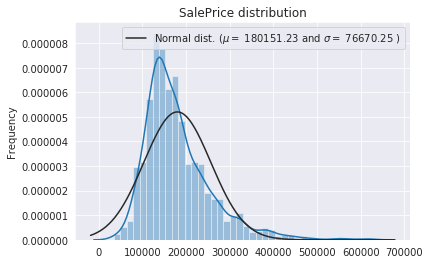

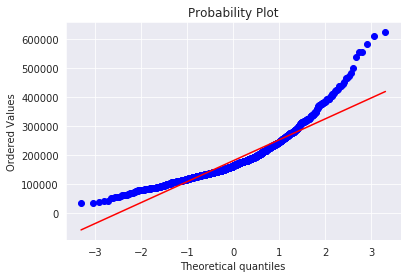

In [12]:
#check the normality of the responds variable
import seaborn as sns
from scipy.stats import norm #for some statistics
import matplotlib.pyplot as plt  # Matlab-style plotting

#histogram plot
sns.distplot(y_train, fit=norm);
#add title axis
(mu, sigma) = norm.fit(y_train)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#use QQ-plot to see the normality
from scipy import stats
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

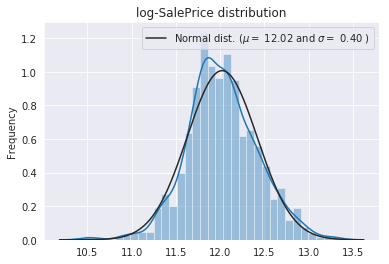

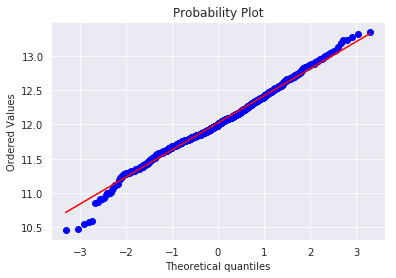

In [13]:
#the respond variable is right skew, we use log transformation to make it more normally.

y_train_log = np.log1p(y_train)#use np.log1p which  applies log(1+x) when the data is close or equal to zero

#Check the new distribution 
sns.distplot(y_train_log , fit=norm);
#add title axis
(mu, sigma) = norm.fit(y_train_log)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('log-SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train_log, plot=plt)
plt.show()

The skew seems now corrected and the data appears more normally distributed.

<a id="models"></a>
# 3. Models

In [14]:
#separate the training and testing data.
x_train = all_data3[:ntrain]
y_train_log= np.log1p(y_train)
x_test = all_data3[ntrain:]

In [22]:
!pip install lightgbm

     |████████████████████████████████| 1.2MB 11.1MB/s eta 0:00:01


In [23]:
#load packages
from sklearn.linear_model import  Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

<a id="lasso"></a>
## 3.1 Linear regression

In [24]:
#lasso
model_lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

#Elastic Net Regression 
model_ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

<a id="xgboost"></a>
## 3.2 Xgboost with Hyper-parameter Tuning

In [25]:
#xgboost with parameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import scipy.stats as st
import datetime

print('####################################################\n{}\start_time'
      .format(datetime.datetime.now().strftime('%H:%M')))

params = {
    'colsample_bytree': [0.4],
    'gamma': st.uniform(0.0,0.05),
    'learning_rate': [0.05], 
    'max_depth':[3],
    'min_child_weight': [2],
    'n_estimators': st.randint(2000,3000),
    'subsample': st.uniform(0.4,0.6),
    'objective':['reg:squarederror'],
    'reg_alpha':st.uniform(0,0.5),
    }

xgb_temp = xgb.XGBRegressor()
model_xgb_tuned = RandomizedSearchCV(xgb_temp, params, n_iter=3,n_jobs=-1)
model_xgb_tuned.fit(x_train,y_train_log)
model_xgb = xgb.XGBRegressor(**model_xgb_tuned.best_params_)

print(model_xgb)
print('{}\tEnd_time\n####################################################'
      .format(datetime.datetime.now().strftime('%H:%M')))

####################################################
07:43\start_time


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


XGBoostError: b'[07:43:53] src/objective/objective.cc:23: Unknown objective function reg:squarederror\n\nStack trace returned 10 entries:\n[bt] (0) /opt/conda/envs/Python36/lib/libxgboost.so(dmlc::StackTrace[abi:cxx11]()+0x55) [0x7f3b9dad67a5]\n[bt] (1) /opt/conda/envs/Python36/lib/libxgboost.so(xgboost::ObjFunction::Create(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&)+0x859) [0x7f3b9db74c49]\n[bt] (2) /opt/conda/envs/Python36/lib/libxgboost.so(xgboost::LearnerImpl::LazyInitModel()+0x25c) [0x7f3b9dae3d9c]\n[bt] (3) /opt/conda/envs/Python36/lib/libxgboost.so(XGBoosterUpdateOneIter+0x73) [0x7f3b9dc577c3]\n[bt] (4) /opt/conda/envs/Python36/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7f3bb047dec0]\n[bt] (5) /opt/conda/envs/Python36/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7f3bb047d87d]\n[bt] (6) /opt/conda/envs/Python36/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7f3bb0693ede]\n[bt] (7) /opt/conda/envs/Python36/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x13915) [0x7f3bb0694915]\n[bt] (8) /opt/conda/envs/Python36/bin/python(_PyObject_FastCallDict+0x8b) [0x55901cdade3b]\n[bt] (9) /opt/conda/envs/Python36/bin/python(+0x199c0e) [0x55901ce35c0e]\n\n'

<a id="LightGBM"></a>
## 3.3 LightGBM with Hyper-parameter Tuning

In [ ]:
#LightGBM: another implementation of grandient boosting 
import lightgbm as lgb

print('####################################################\n{}\start_time'
      .format(datetime.datetime.now().strftime('%H:%M')))

params = {
    'objective':['regression'],
    'num_leaves':[4,5],
    'learning_rate':[0.05], 
    'n_estimators': [700,5000],
    'max_bin': [50,200], 
    'bagging_fraction':[0.75],
    'bagging_freq':[5],
    'bagging_seed':[7], 
    'feature_fraction':[0.2],
    'feature_fraction_seed':[7] 
    }



light_temp = lgb.LGBMRegressor()
model_lgb_tuned = GridSearchCV(light_temp, params, n_jobs=-1)
model_lgb_tuned.fit(x_train,y_train_log)
model_lgb = lgb.LGBMRegressor(**model_lgb_tuned.best_params_)

print(model_lgb)
print('{}\tEnd_time\n####################################################'
      .format(datetime.datetime.now().strftime('%H:%M')))

####################################################
07:44\start_time


<a id="rf"></a>
## 3.4 Random Forest with Hyper-parameter Tuning

In [ ]:
#random forest

from sklearn.ensemble import RandomForestRegressor
print('####################################################\n{}\start_time'
      .format(datetime.datetime.now().strftime('%H:%M')))

params = {
    'max_depth': [20,None],
    'min_samples_leaf': [2],
    'min_samples_split': [4],
    'n_estimators': [200,500],
    }

rf_temp = RandomForestRegressor()
rf_temp_tuned = GridSearchCV(rf_temp, params, n_jobs=-1)
rf_temp_tuned.fit(x_train,y_train_log)
model_randomforest = RandomForestRegressor(**rf_temp_tuned.best_params_)

print(model_randomforest)
print('{}\tEnd_time\n####################################################'
      .format(datetime.datetime.now().strftime('%H:%M')))

<a id="stacking"></a>
## 3.5 Use Cross Validation to Compare the Performance and Stacking the Models

In [ ]:
#Use cross validation to compare the performance
from sklearn.model_selection import KFold

#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train)
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train_log, scoring="neg_mean_squared_error", cv = kf))
    return(rmse.mean())

models = {
    'Lightgbm':model_lgb,
    'XGBoost':model_xgb,
    'Lasso':model_lasso,
    'Random forest':model_randomforest,
    'Elastic Net':model_ENet
    }

for model_ind, model_fn in models.items():
    print('Fitting:\t{}'.format(model_ind))
    model_fn.fit(x_train, y_train_log)
    print('Done! Error:\t{}\n'.format(rmsle_cv(model_fn)))

    
#combine the models   
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)   

#combine the model together(stacking)
averaged_models = AveragingModels(models = (model_lgb, model_xgb,model_lasso,model_ENet))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: \t{}\n".format(score))

<a id="predictions"></a>
## 4. Predictions and Submit the Results

In [ ]:
#We use the stacked model for our final predictions.

averaged_models.fit(x_train, y_train_log)
y_pred=averaged_models.predict(x_test)

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = np.expm1(y_pred)
sub.to_csv('Aaron_submission.csv',index=False)